# VGG16 - CNN

This notebook uses the VGG16 model architecture.

In [64]:
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [65]:
# Config
IMG_SIZE = 200
BATCH_SIZE=32
train_path = 'data/train/'
test_path = 'data/test/'
val_path = 'data/val/'
covid19_path = 'data/covid19/'

## 1 Data preparation

In [66]:
def load_images_from_folder(folder):
    tmp_df = pd.DataFrame(columns = ['path', 'label', 'label2'])
    
    for label_folder in os.listdir(folder):
        print(label_folder)
        for filename in os.listdir(folder + '/' + label_folder):
            img_path = str(folder)+str(label_folder)+'/'+str(filename)
            if img_path is not None:
                tmp_df = tmp_df.append({'path': img_path, 'label': label_folder}, ignore_index=True)
    return tmp_df

In [67]:
def load_covid19images_from_folder(folder):
    tmp_df = pd.DataFrame(columns = ['path', 'label', 'label2'])
    for filename in os.listdir(folder):
        img_path = str(folder)+str(filename)
        if img_path is not None:
            tmp_df = tmp_df.append({'path': img_path, 'label': 'PNEUMONIA', 'label2': 'COVID-19'}, ignore_index=True)
    return tmp_df

In [68]:
df_train = load_images_from_folder(train_path)
df_val = load_images_from_folder(val_path)
df_test = load_images_from_folder(test_path)

NORMAL
PNEUMONIA
NORMAL
PNEUMONIA
NORMAL
PNEUMONIA


In [69]:
df_train

,path,label,label2
0,data/train/NORMAL/IM-0115-0001.jpeg,NORMAL,NaN
1,data/train/NORMAL/IM-0117-0001.jpeg,NORMAL,NaN
2,data/train/NORMAL/IM-0119-0001.jpeg,NORMAL,NaN
3,data/train/NORMAL/IM-0122-0001.jpeg,NORMAL,NaN
4,data/train/NORMAL/IM-0125-0001.jpeg,NORMAL,NaN
...,...,...,...
5211,data/train/PNEUMONIA/person99_virus_183.jpeg,PNEUMONIA,NaN
5212,data/train/PNEUMONIA/person9_bacteria_38.jpeg,PNEUMONIA,NaN
5213,data/train/PNEUMONIA/person9_bacteria_39.jpeg,PNEUMONIA,NaN
5214,data/train/PNEUMONIA/person9_bacteria_40.jpeg,PNEUMONIA,NaN


In [70]:
len(df_train)

5216

In [71]:
# we removed 3 side x ray imgs (blacklisted)
df_covid19 = load_covid19images_from_folder(covid19_path)

In [72]:
train_covid19 = df_covid19.sample(frac = 0.8,random_state=200)
test_covid19 = df_covid19.drop(train_covid19.index).sample(frac = 0.5,random_state=200)
val_covid19 = df_covid19.drop(train_covid19.index).drop(test_covid19.index)

In [73]:
print('=== COVID-19 Split: ===')
print('Train:', len(train_covid19))
print('Val:', len(val_covid19))
print('Test:', len(test_covid19))

=== COVID-19 Split: ===
Train: 175
Val: 22
Test: 22


In [74]:
# Train
df_train = df_train.append(train_covid19, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True) # shuffle covid19 under the rest

# Val
df_val = df_val.append(val_covid19, ignore_index=True)
df_val = df_val.sample(frac=1).reset_index(drop=True) # shuffle covid19 under the rest

# Test
df_test = df_test.append(test_covid19, ignore_index=True)
df_test = df_test.sample(frac=1).reset_index(drop=True) # shuffle covid19 under the rest

In [75]:
# Append some more test data to val, since there are such few.. 
df_add_val = df_test[:175] # 175 see baseline paper
df_test = df_test[:-175]

In [76]:
df_val = df_val.append(df_add_val, ignore_index=True)

In [77]:
print('=== Data: ===')
print('Train:', len(df_train))
print('Val:', len(df_val))
print('Test:', len(df_test))

=== Data: ===
Train: 5391
Val: 213
Test: 471


## 2 Data generator

In [78]:
# Training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range=0.2,
        horizontal_flip = True,
        fill_mode="nearest",
        zoom_range=0.2)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = df_train,
        target_size = (IMG_SIZE, IMG_SIZE),
        directory = None,
        x_col='path',
        y_col='label',
        batch_size = BATCH_SIZE,
        class_mode = "binary",
        shuffle=False)

# Validation
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
        dataframe = df_val,
        target_size = (IMG_SIZE, IMG_SIZE),
        directory = None,
        x_col='path',
        y_col='label',
        class_mode = "binary",
        shuffle=False)

test_generator = val_datagen.flow_from_dataframe(
        dataframe = df_test,
        target_size = (IMG_SIZE, IMG_SIZE),
        directory = None,
        x_col='path',
        y_col='label',
        class_mode = "binary",
        shuffle=False)

Found 5391 validated image filenames belonging to 2 classes.
Found 213 validated image filenames belonging to 2 classes.
Found 471 validated image filenames belonging to 2 classes.


## 3 Modeltraining

In [79]:
# Based on the model of: https://ieeexplore.ieee.org/abstract/document/9057809
# Feature Extraction and Classification of Chest X-Ray Images Using CNN to Detect Pneumonia

base_model = VGG16(include_top=False,
                  input_shape = (64,64,3),
                  weights = 'imagenet')

for layer in base_model.layers[:-12]:
    layer.trainable = False

model = Sequential()
model.add(base_model)

model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [80]:
# history = model.fit(train_generator, validation_data=val_generator, callbacks=[early_stopping], epochs=20, verbose = True)
history = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // BATCH_SIZE,
                    epochs=20,
                    verbose = True)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
168/168 [==============================] - ETA: 0s - loss: 0.3984 - accuracy: 0.8035WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000202AA2F3598> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

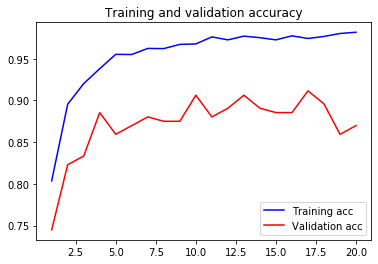

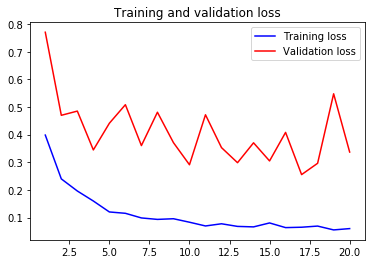

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 4 Model evaluation

In [82]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(test_generator)
print('test loss, test acc:', results)


# Evaluate on test data
15/15 [==============================] - 5s 301ms/step - loss: 0.3561 - accuracy: 0.8790
test loss, test acc: [0.3560657203197479, 0.8789808750152588]


In [93]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.round(predictions)

In [94]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [95]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.96      0.67      0.79       163
   PNEUMONIA       0.85      0.99      0.91       308

    accuracy                           0.88       471
   macro avg       0.91      0.83      0.85       471
weighted avg       0.89      0.88      0.87       471



In [96]:
y_true = test_generator.classes
y_pred = predictions > 0.5

In [97]:
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix/data
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [98]:
y_pred = np.round(predictions)
cm = confusion_matrix(test_generator.classes, y_pred)

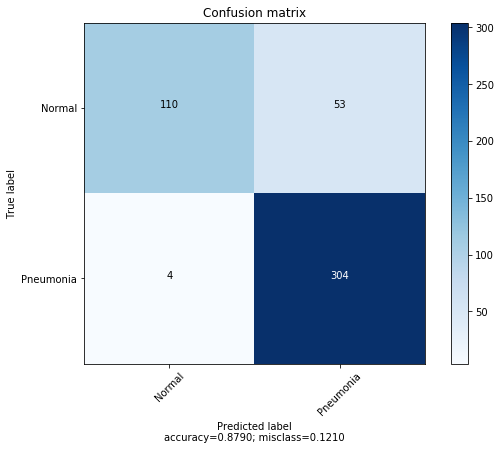

In [99]:
plot_confusion_matrix(cm, ['Normal', 'Pneumonia'], normalize=False)